In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [ ]:
files = zf.ZipFile("/content/dataset-resized.zip",'r')
files.extractall()
files.close()

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['plastic', 'metal', 'paper', '.DS_Store', 'glass', 'cardboard', 'trash']

In [ ]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [ ]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


In [ ]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [ ]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


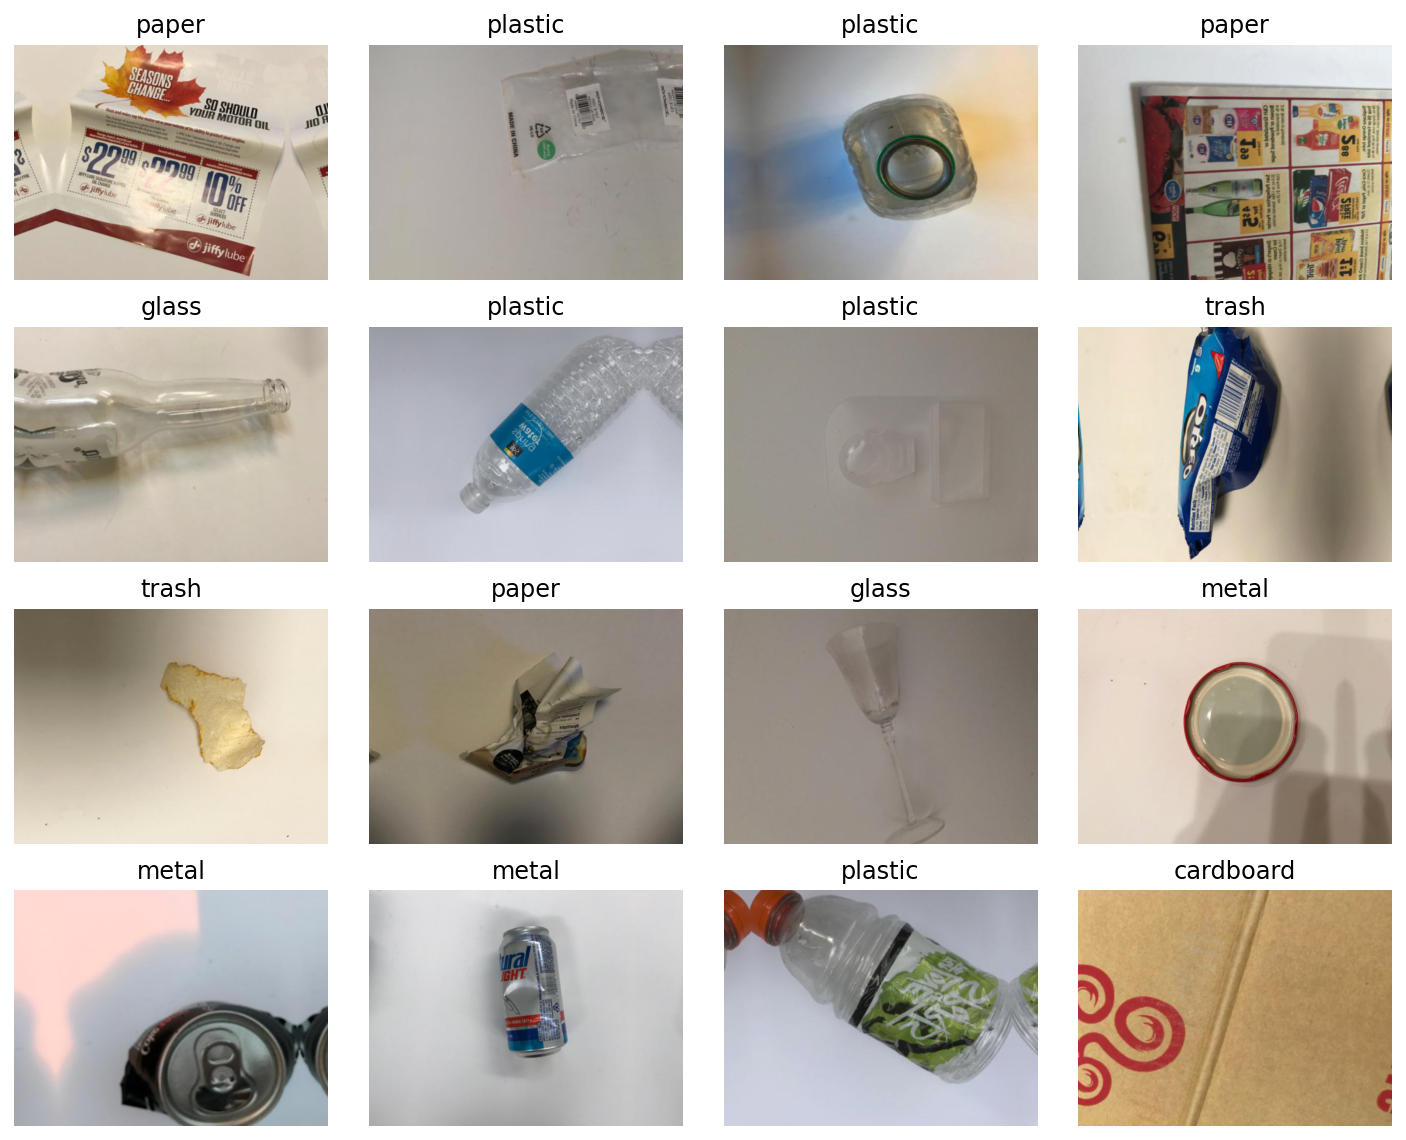

In [ ]:
data.show_batch(rows=4,figsize=(10,8))

In [ ]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


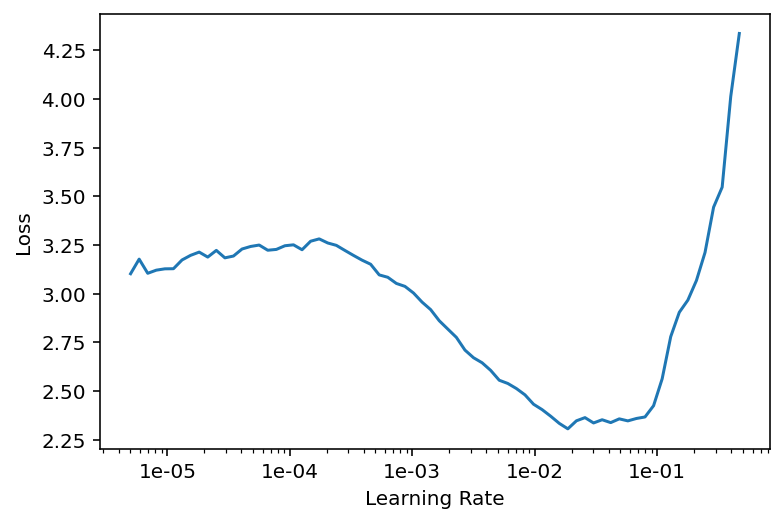

In [ ]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.804729,0.706193,0.261905,00:38
1,1.104387,0.509692,0.184127,00:38
2,0.950541,0.649227,0.203175,00:38
3,0.869222,0.558646,0.185714,00:38
4,0.863002,0.599118,0.188889,00:38
5,0.868809,0.991334,0.298413,00:38
6,0.746470,0.596565,0.188889,00:38
7,0.664635,0.465165,0.139683,00:38
8,0.607079,0.506260,0.157143,00:38
9,0.602229,0.610245,0.190476,00:38


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

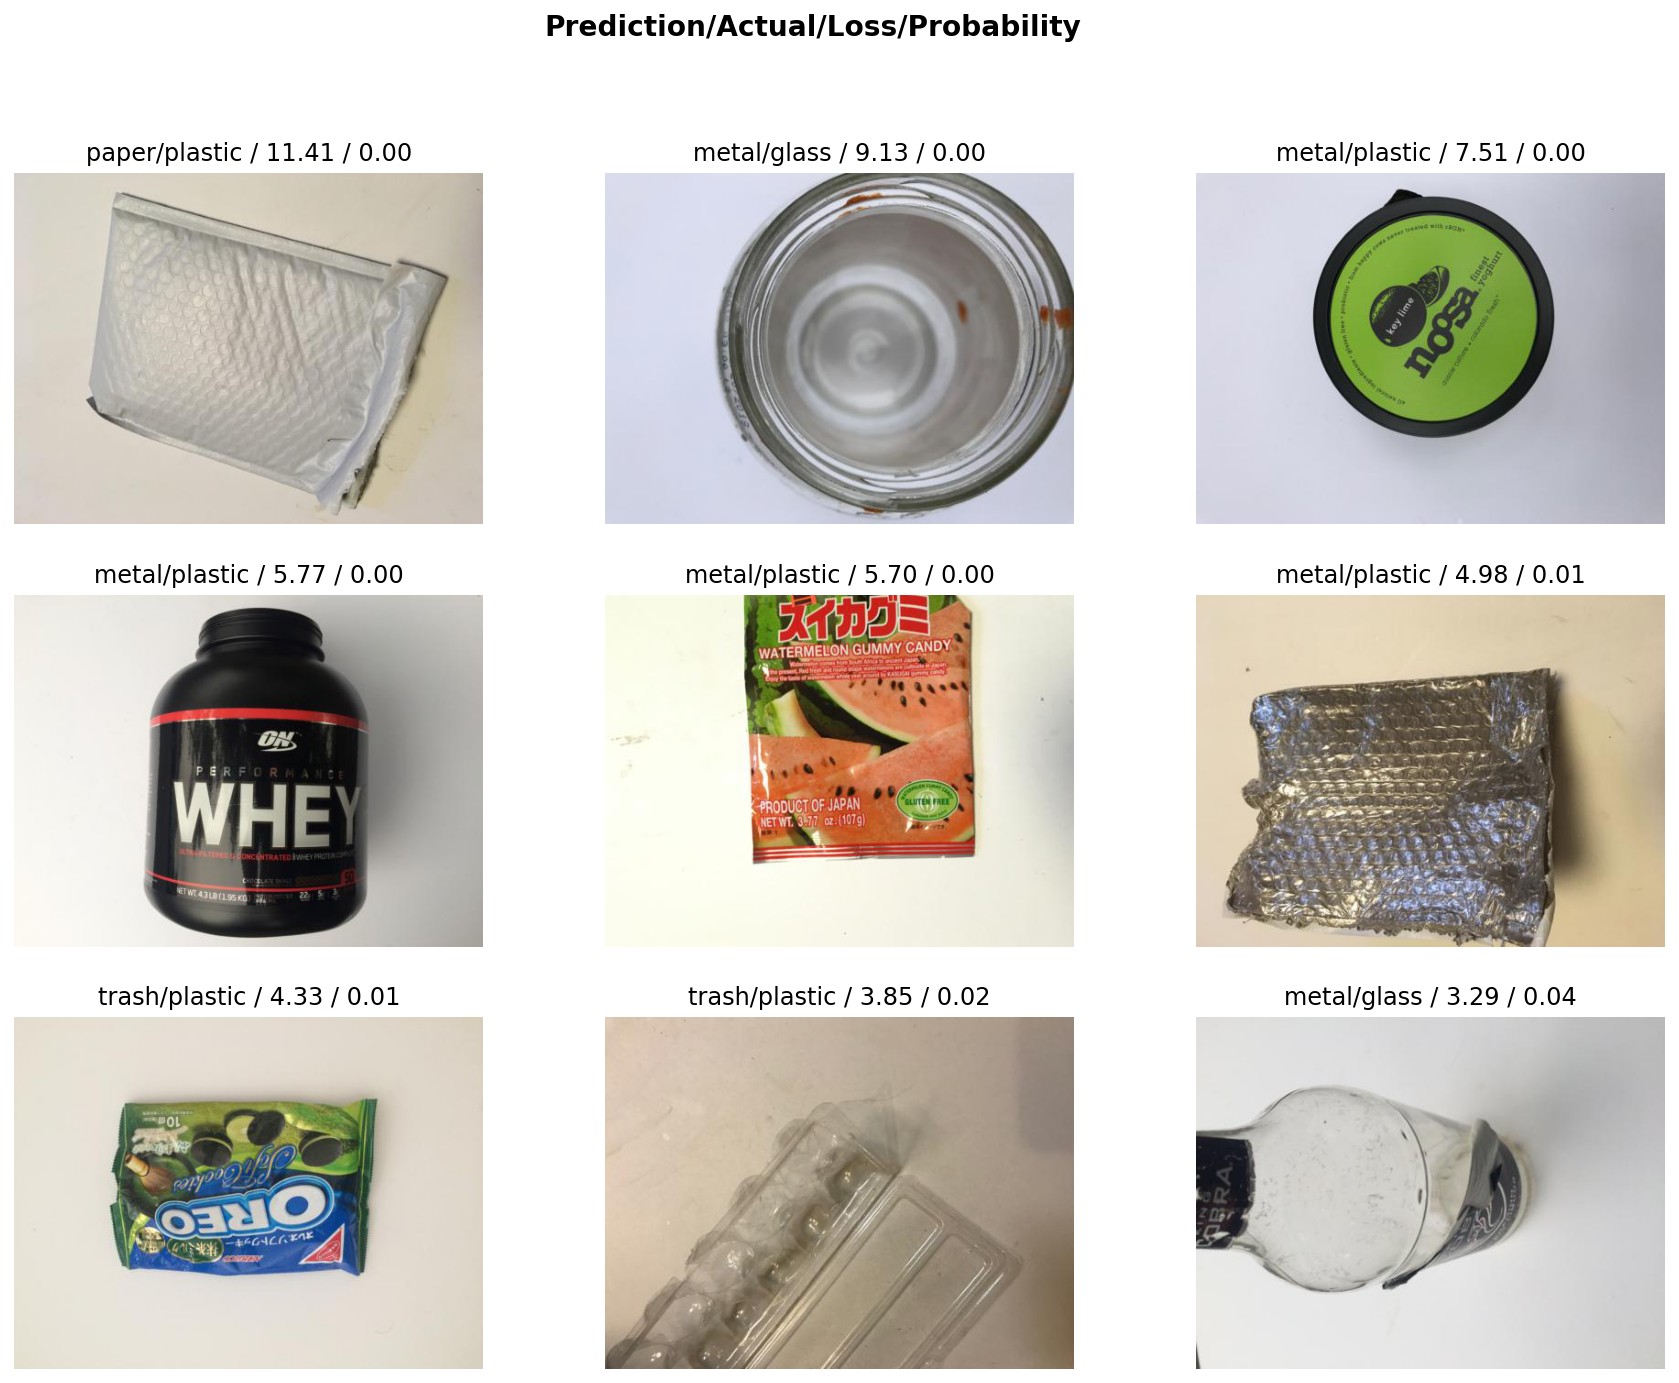

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

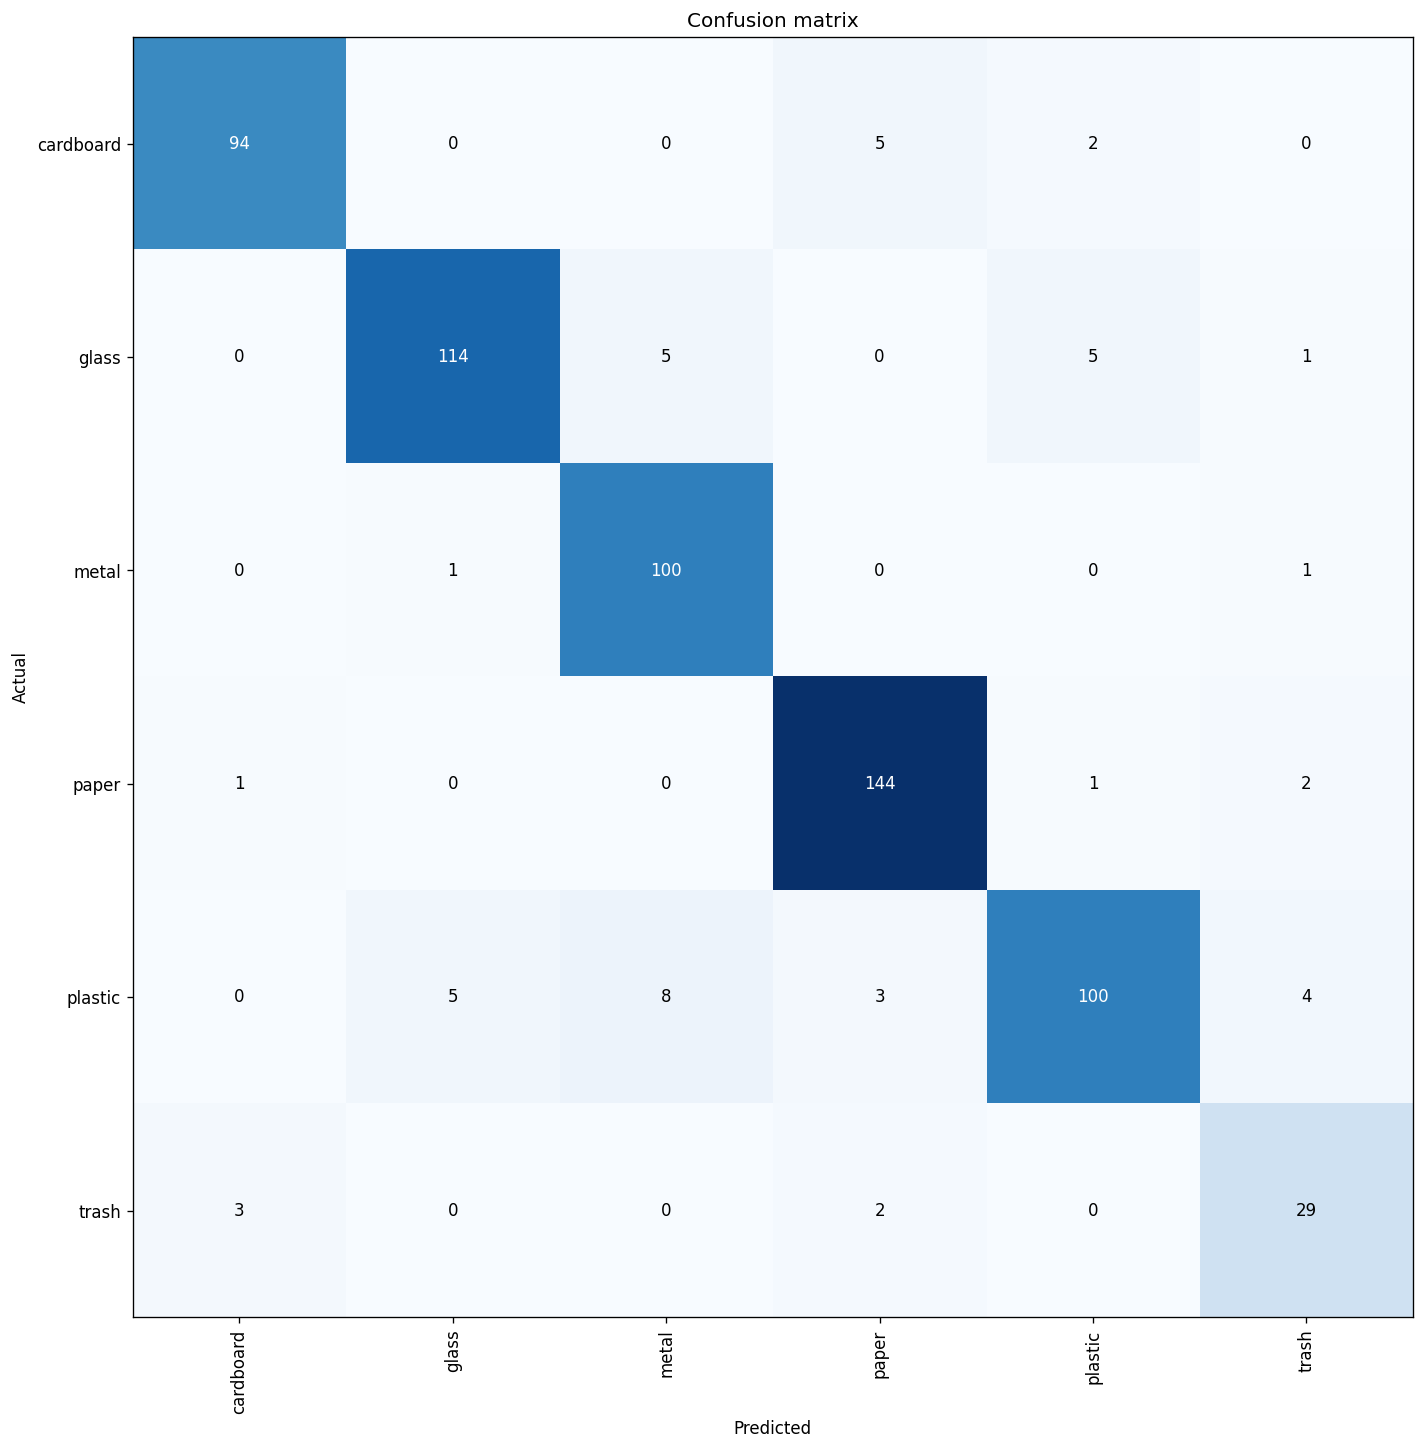

In [ ]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('plastic', 'metal', 8),
 ('cardboard', 'paper', 5),
 ('glass', 'metal', 5),
 ('glass', 'plastic', 5),
 ('plastic', 'glass', 5),
 ('plastic', 'trash', 4),
 ('plastic', 'paper', 3),
 ('trash', 'cardboard', 3),
 ('cardboard', 'plastic', 2),
 ('paper', 'trash', 2),
 ('trash', 'paper', 2)]

In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9935e-01, 6.2272e-05, 2.3154e-05, 3.3791e-04, 4.4380e-05, 1.7911e-04],
        [2.6935e-07, 9.9984e-01, 1.3903e-04, 1.8655e-07, 1.4321e-05, 4.7835e-06],
        [5.1375e-06, 1.9931e-04, 9.9970e-01, 7.3202e-06, 6.5148e-05, 2.4079e-05],
        ...,
        [9.9999e-01, 1.0873e-06, 4.7897e-07, 1.2457e-05, 2.6761e-07, 2.7685e-07],
        [9.9944e-01, 5.2496e-04, 1.1201e-05, 1.3236e-05, 9.6192e-07, 4.8880e-06],
        [7.3292e-07, 9.0685e-06, 9.9996e-01, 2.4943e-05, 5.1315e-07, 3.4929e-06]])

In [ ]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [ ]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [ ]:
yhat

['cardboard',
 'glass',
 'metal',
 'glass',
 'cardboard',
 'plastic',
 'plastic',
 'metal',
 'glass',
 'metal',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'trash',
 'paper',
 'cardboard',
 'paper',
 'plastic',
 'metal',
 'glass',
 'plastic',
 'trash',
 'cardboard',
 'glass',
 'paper',
 'paper',
 'glass',
 'glass',
 'metal',
 'glass',
 'plastic',
 'glass',
 'glass',
 'cardboard',
 'cardboard',
 'cardboard',
 'paper',
 'cardboard',
 'paper',
 'metal',
 'glass',
 'plastic',
 'glass',
 'plastic',
 'paper',
 'glass',
 'trash',
 'plastic',
 'cardboard',
 'glass',
 'paper',
 'paper',
 'glass',
 'glass',
 'glass',
 'metal',
 'plastic',
 'glass',
 'cardboard',
 'glass',
 'paper',
 'plastic',
 'glass',
 'metal',
 'paper',
 'metal',
 'glass',
 'paper',
 'metal',
 'glass',
 'metal',
 'glass',
 'glass',
 'paper',
 'metal',
 'glass',
 'metal',
 'cardboard',
 'metal',
 'glass',
 'paper',
 'plastic',
 'metal',
 'cardboard',
 'glass',
 'paper',
 'glass',
 'plastic',
 'trash',
 'trash',
 'trash',
 '

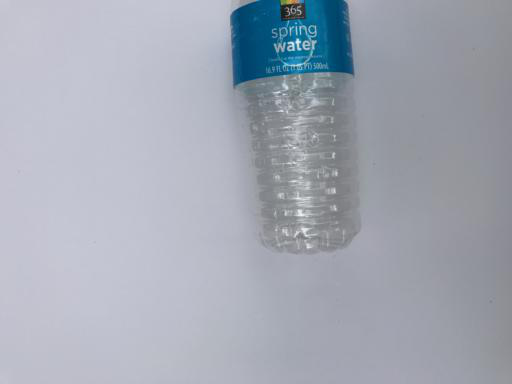

In [ ]:
learn.data.test_ds[100][0]


In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [ ]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'glass', 'metal', 'glass', 'cardboard']
['cardboard', 'glass', 'metal', 'glass', 'cardboard']


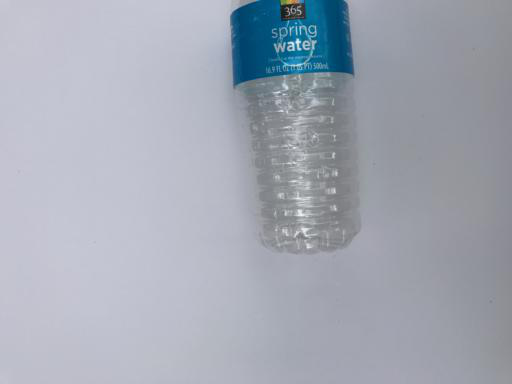

In [ ]:
learn.data.test_ds[100][0]

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   2   2   0   0]
 [  0 115   6   0   5   0]
 [  0  10  90   0   1   2]
 [  0   0   2 145   0   2]
 [  0   4   0   1 111   5]
 [  0   0   1   4   3  27]]


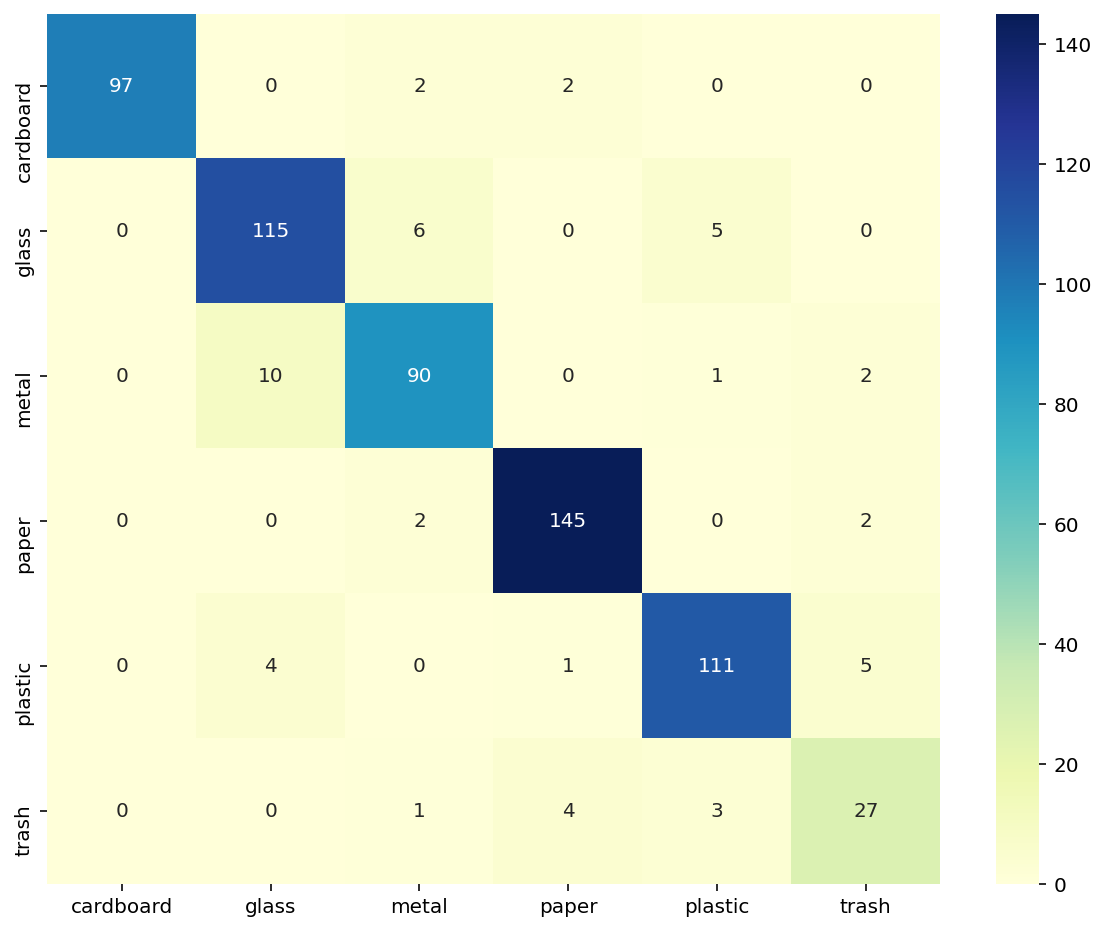

In [ ]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

0.9212598425196851